In [ ]:
import torch
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4376, 0.4438, 0.4723), (0.2070, 0.2070, 0.2070))])


trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)


testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)


### Standard model

In [ ]:
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp


model = resnet18()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def train_model(model, criterion, optimizer, num_epochs, train_loader):
    train_losses = []
    train_accuracies = []
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        loss_epoch = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            loss_epoch.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(sum(loss_epoch)/len(loss_epoch))
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {sum(train_losses)/len(train_losses):.4f}, Train Accuracy: {train_accuracy:.4f}')

    return train_losses, train_accuracies

train_losses, train_accuracies = train_model(model, criterion, optimizer, num_epochs, trainloader)

torch.save(model.state_dict(), 'resnet18_svhn.pth')


Epoch 1/10 - Train Loss: 0.7399, Train Accuracy: 0.7640

Epoch 2/10 - Train Loss: 0.5506, Train Accuracy: 0.8903

Epoch 3/10 - Train Loss: 0.4608, Train Accuracy: 0.9154

Epoch 4/10 - Train Loss: 0.4030, Train Accuracy: 0.9317

Epoch 5/10 - Train Loss: 0.3610, Train Accuracy: 0.9425

Epoch 6/10 - Train Loss: 0.3282, Train Accuracy: 0.9509

Epoch 7/10 - Train Loss: 0.3011, Train Accuracy: 0.9584

Epoch 8/10 - Train Loss: 0.2781, Train Accuracy: 0.9642

Epoch 9/10 - Train Loss: 0.2584, Train Accuracy: 0.9684

Epoch 10/10 - Train Loss: 0.2411, Train Accuracy: 0.9732


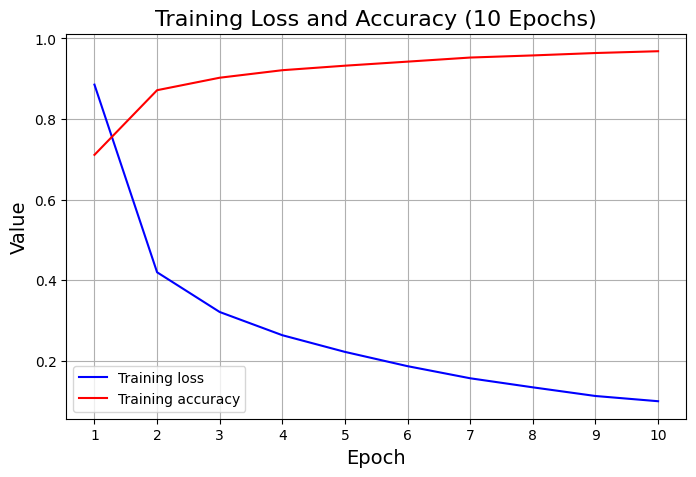

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))

    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')

    plt.grid(True)
    plt.title('Training Loss and Accuracy (10 Epochs)', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.xticks(range(1, len(train_losses) + 1))

    plt.show()

plot_metrics(train_losses, train_accuracies)

In [ ]:

model.eval()


correct = 0
total = 0

with torch.no_grad():
    for data in testloader:

        inputs, labels = data


        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()


        outputs = model(inputs)


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = 100 * correct / total

print(f'Accuracy of the model on the test images: {accuracy}%')


Accuracy of the model on the test images: 92.12507682851874%


In [ ]:
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize(( 32 , 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307, 0.1307, 0.1307], std=[0.3081, 0.3081, 0.3081]),
])

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=True)


In [ ]:

model.eval()


correct = 0
total = 0


with torch.no_grad():
    for data in mnist_testloader:

        inputs, labels = data


        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()


        outputs = model(inputs)


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = 100 * correct / total

print(f'Accuracy of the model on the MNIST test images: {accuracy}%')


Accuracy of the model on the MNIST test images: 66.72%


### Without batch normalization

In [ ]:
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlockNoBN(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlockNoBN, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)

        out = self.conv2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNetNoBN(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNetNoBN, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=True),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet18_no_bn(pretrained=False, **kwargs):
    model = ResNetNoBN(BasicBlockNoBN, [2, 2, 2, 2], **kwargs)
    return model



In [ ]:
import torch.optim as optim
import torch

model_no_bn = resnet18_no_bn()



criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_no_bn.parameters(), lr=0.001, momentum=0.9)


num_epochs = 10


if torch.cuda.is_available():
    model_no_bn = model_no_bn.cuda()


epoch_loss = []
epoch_accuracy = []


for epoch in range(num_epochs):
    running_loss = 0.0
    total_batches = 0
    correct_predictions = 0
    total_predictions = 0

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data


        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()


        optimizer.zero_grad()


        outputs = model_no_bn(inputs)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        total_batches += 1


        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)


    average_loss = running_loss / total_batches
    accuracy = correct_predictions / total_predictions
    epoch_loss.append(average_loss)
    epoch_accuracy.append(accuracy)

    print(f'Epoch {epoch+1}, Loss: {average_loss}, Accuracy: {accuracy}')

print('Finished Training')

Epoch 1, Loss: 2.0260554918245237, Accuracy: 0.2721241656087473
Epoch 2, Loss: 0.6946866986603945, Accuracy: 0.7857542623913073
Epoch 3, Loss: 0.4412158994361283, Accuracy: 0.867862456830064
Epoch 4, Loss: 0.3551048819157924, Accuracy: 0.893238871370654
Epoch 5, Loss: 0.3012252236906822, Accuracy: 0.9090325839168953
Epoch 6, Loss: 0.2620664032214883, Accuracy: 0.9214409544480391
Epoch 7, Loss: 0.23297000233271642, Accuracy: 0.930846198998048
Epoch 8, Loss: 0.2060499514426952, Accuracy: 0.939104795446169
Epoch 9, Loss: 0.1817315848748221, Accuracy: 0.9464624540999494
Epoch 10, Loss: 0.16344489128682047, Accuracy: 0.9514858648320297
Finished Training


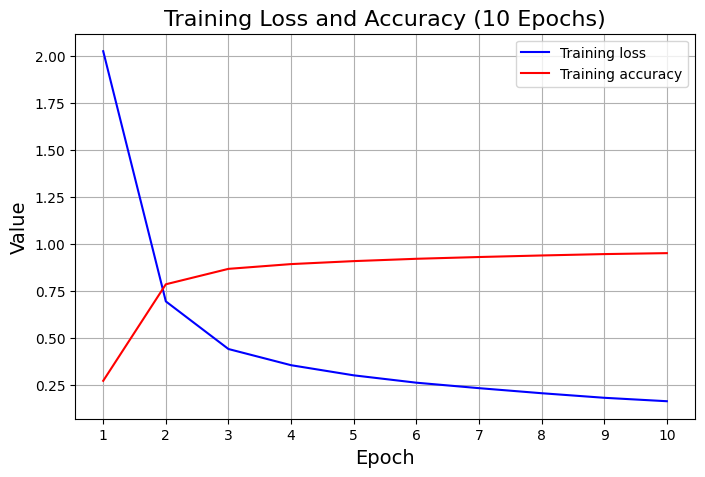

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))

    plt.plot(epochs, epoch_loss, 'b', label='Training loss')
    plt.plot(epochs, epoch_accuracy, 'r', label='Training accuracy')

    plt.grid(True)
    plt.title('Training Loss and Accuracy (10 Epochs)', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.xticks(range(1, len(train_losses) + 1))

    plt.show()

plot_metrics(epoch_loss, epoch_accuracy)

In [ ]:
model_no_bn.eval()

correct = 0
total = 0


with torch.no_grad():
    for data in testloader:

        inputs, labels = data


        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()


        outputs = model_no_bn(inputs)


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = 100 * correct / total

print(f'Accuracy of the model on the test images: {accuracy}%')


Accuracy of the model on the test images: 91.79471419791027%


In [ ]:
model_no_bn.eval()

correct = 0
total = 0


with torch.no_grad():
    for data in mnist_testloader:

        inputs, labels = data


        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()


        outputs = model_no_bn(inputs)


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = 100 * correct / total

print(f'Accuracy of the model on the MNIST test images: {accuracy}%')


Accuracy of the model on the MNIST test images: 65.13%


### Label smoothing

In [ ]:
model_label_smoothing = resnet18()

In [ ]:
import torch

def smooth_labels(labels, num_classes, epsilon=0.1):
    # Convert labels to one-hot encoding
    one_hot = torch.zeros(labels.size(0), num_classes, device=labels.device)
    one_hot.scatter_(1, labels.view(-1, 1), 1)

    # Smooth the labels
    smoothed_labels = one_hot * (1 - epsilon) + (epsilon / num_classes)

    return smoothed_labels


In [ ]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_label_smoothing.parameters(), lr=0.001, momentum=0.9)


num_epochs = 10


if torch.cuda.is_available():
    model_label_smoothing = model_label_smoothing.cuda()


epoch_loss = []
epoch_accuracy = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        smoothed_labels = smooth_labels(labels,num_classes=10, epsilon=0.25)  # Adjust alpha as needed


        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
            smoothed_labels = smoothed_labels.cuda()

        optimizer.zero_grad()


        outputs = model_label_smoothing(inputs)
        loss = criterion(outputs, smoothed_labels)


        loss.backward()
        optimizer.step()


        running_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)


    average_loss = running_loss / len(trainloader)
    accuracy = correct_predictions / total_predictions

    epoch_loss.append(average_loss)
    epoch_accuracy.append(accuracy)

    print(f'Epoch {epoch+1}, Loss: {average_loss}, Accuracy: {accuracy}')
print('Finished Training')

Epoch 1, Loss: 1.4522394161345162, Accuracy: 0.7593813560478863
Epoch 2, Loss: 1.2275493271253495, Accuracy: 0.8927611013282007
Epoch 3, Loss: 1.1821260142466938, Accuracy: 0.9175778423904882
Epoch 4, Loss: 1.1532702214802735, Accuracy: 0.933617265244277
Epoch 5, Loss: 1.1332273490305524, Accuracy: 0.945561516305609
Epoch 6, Loss: 1.1169897940357223, Accuracy: 0.9546391471122213
Epoch 7, Loss: 1.1046330610928408, Accuracy: 0.9609730128178877
Epoch 8, Loss: 1.0915046804569308, Accuracy: 0.968508128916008
Epoch 9, Loss: 1.082382672867626, Accuracy: 0.9734086844943145
Epoch 10, Loss: 1.074792290233738, Accuracy: 0.9776130608679034
Finished Training


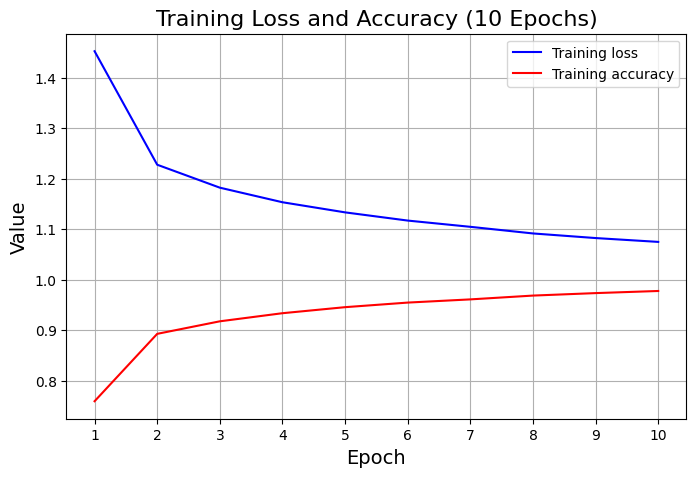

In [ ]:
plot_metrics(epoch_loss, epoch_accuracy)

In [ ]:

model_label_smoothing.eval()

correct = 0
total = 0


with torch.no_grad():
    for data in testloader:

        inputs, labels = data


        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()


        outputs = model_label_smoothing(inputs)


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = 100 * correct / total

print(f'Accuracy of the model on the test images: {accuracy}%')


Accuracy of the model on the test images: 92.27873386601107%


In [ ]:

model_label_smoothing.eval()


correct = 0
total = 0


with torch.no_grad():
    for data in mnist_testloader:

        inputs, labels = data


        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()


        outputs = model_label_smoothing(inputs)


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = 100 * correct / total

print(f'Accuracy of the model on the MNIST test images: {accuracy}%')


Accuracy of the model on the MNIST test images: 70.89%


### augmentation

In [ ]:
import torch
from torchvision import datasets, transforms


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.2154, 0.2028)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.2154, 0.2028)),
])


trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform_train)
trainloader_aug = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)


testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform_test)
testloader_aug = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)


In [ ]:
model_aug = resnet18()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_aug.parameters(), lr=0.001, momentum=0.9)


num_epochs = 10


if torch.cuda.is_available():
    model_aug = model_aug.cuda()


epoch_loss_aug = []
epoch_accuracy_aug = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, data in enumerate(trainloader_aug, 0):

        inputs, labels = data



        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model_aug(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    average_loss = running_loss / len(trainloader)
    accuracy = correct_predictions / total_predictions

    epoch_loss_aug.append(average_loss)
    epoch_accuracy_aug.append(accuracy)

    print(f'Epoch {epoch+1}, Loss: {average_loss}, Accuracy: {accuracy}')

print('Finished Training')


Epoch 1, Loss: 1.381180826513547, Accuracy: 0.5363309990854116
Epoch 2, Loss: 0.6535479488157567, Accuracy: 0.7949547483516933
Epoch 3, Loss: 0.523550896024074, Accuracy: 0.8368483557885253
Epoch 4, Loss: 0.4663366951118747, Accuracy: 0.8555359897347694
Epoch 5, Loss: 0.42942124350615973, Accuracy: 0.8674392890781768
Epoch 6, Loss: 0.40115359909002646, Accuracy: 0.8761074027055435
Epoch 7, Loss: 0.3802179716461157, Accuracy: 0.8820727029498887
Epoch 8, Loss: 0.3602624267403164, Accuracy: 0.8894167110310277
Epoch 9, Loss: 0.3456153162159343, Accuracy: 0.8945766274895232
Epoch 10, Loss: 0.3353338274068693, Accuracy: 0.8980165717951868
Finished Training


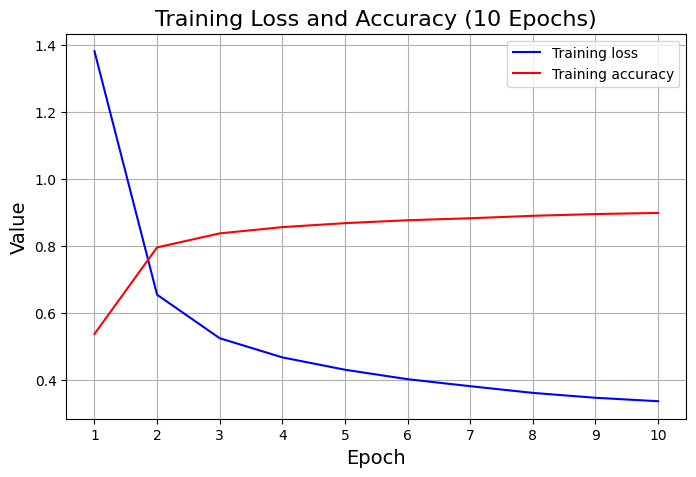

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))

    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')

    plt.grid(True)
    plt.title('Training Loss and Accuracy (10 Epochs)', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.xticks(range(1, len(train_losses) + 1))

    plt.show()

plot_metrics(epoch_loss_aug, epoch_accuracy_aug)

In [ ]:

model_aug.eval()


correct = 0
total = 0


with torch.no_grad():
    for data in testloader_aug:

        inputs, labels = data


        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model_aug(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = 100 * correct / total

print(f'Accuracy of the model on the test images: {accuracy}%')


Accuracy of the model on the test images: 93.50030731407499%


In [ ]:
model_aug.eval()

correct = 0
total = 0


with torch.no_grad():
    for data in mnist_testloader:

        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model_aug(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy of the model on the MNIST test images: {accuracy}%')


Accuracy of the model on the MNIST test images: 69.13%


### Pretrained resnet

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


resnet_pre = models.resnet18(pretrained=True)


num_classes = 10
resnet_pre.fc = nn.Linear(resnet_pre.fc.in_features, num_classes)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp



criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_pre.parameters(), lr=0.001, momentum=0.9)


num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_pre.to(device)



def train_model(model, criterion, optimizer, num_epochs, train_loader):
    train_losses = []
    train_accuracies = []
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        loss_epoch = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            loss_epoch.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(sum(loss_epoch)/len(loss_epoch))
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {sum(train_losses)/len(train_losses):.4f}, Train Accuracy: {train_accuracy:.4f}')

    return train_losses, train_accuracies

train_losses_pre, train_accuracies_pre = train_model(resnet_pre, criterion, optimizer, num_epochs, trainloader)




Epoch 1/10 - Train Loss: 0.6568, Train Accuracy: 0.7947
Epoch 2/10 - Train Loss: 0.4986, Train Accuracy: 0.8989
Epoch 3/10 - Train Loss: 0.4216, Train Accuracy: 0.9223
Epoch 4/10 - Train Loss: 0.3718, Train Accuracy: 0.9351
Epoch 5/10 - Train Loss: 0.3355, Train Accuracy: 0.9448
Epoch 6/10 - Train Loss: 0.3076, Train Accuracy: 0.9505
Epoch 7/10 - Train Loss: 0.2844, Train Accuracy: 0.9576
Epoch 8/10 - Train Loss: 0.2653, Train Accuracy: 0.9616
Epoch 9/10 - Train Loss: 0.2483, Train Accuracy: 0.9668
Epoch 10/10 - Train Loss: 0.2337, Train Accuracy: 0.9692


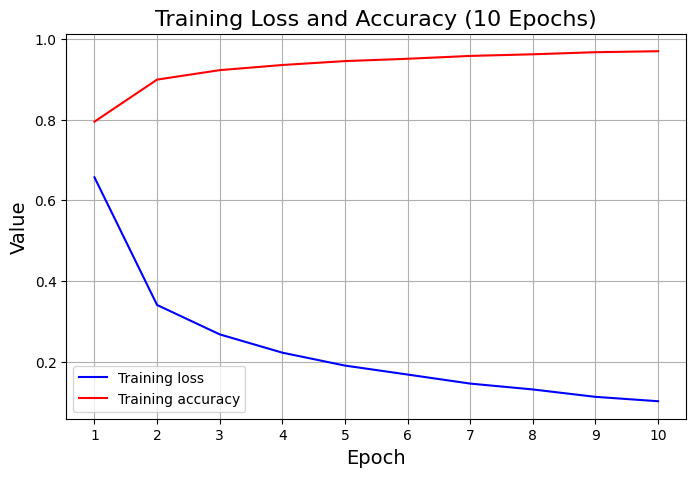

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))

    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')

    plt.grid(True)
    plt.title('Training Loss and Accuracy (10 Epochs)', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.xticks(range(1, len(train_losses) + 1))

    plt.show()

plot_metrics(train_losses_pre, train_accuracies_pre)

In [ ]:

resnet_pre.eval()


correct = 0
total = 0


with torch.no_grad():
    for data in testloader:

        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = resnet_pre(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy of the model on the test images: {accuracy}%')


Accuracy of the model on the test images: 93.56945298094652%


In [ ]:
resnet_pre.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in mnist_testloader:

        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = resnet_pre(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy of the model on the MNIST test images: {accuracy}%')


Accuracy of the model on the MNIST test images: 71.84%


### optimizer

In [ ]:
model_optimizer = resnet18()


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_optimizer.parameters(), lr= 0.001)



num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_optimizer.to(device)


train_losses_opt, train_accuracies_opt = train_model(model_optimizer, criterion, optimizer, num_epochs, trainloader)

Epoch 1/10 - Train Loss: 0.8616, Train Accuracy: 0.7260
Epoch 2/10 - Train Loss: 0.6472, Train Accuracy: 0.8732
Epoch 3/10 - Train Loss: 0.5462, Train Accuracy: 0.8984
Epoch 4/10 - Train Loss: 0.4807, Train Accuracy: 0.9170
Epoch 5/10 - Train Loss: 0.4335, Train Accuracy: 0.9287
Epoch 6/10 - Train Loss: 0.3970, Train Accuracy: 0.9379
Epoch 7/10 - Train Loss: 0.3662, Train Accuracy: 0.9470
Epoch 8/10 - Train Loss: 0.3403, Train Accuracy: 0.9538
Epoch 9/10 - Train Loss: 0.3175, Train Accuracy: 0.9603
Epoch 10/10 - Train Loss: 0.2973, Train Accuracy: 0.9657


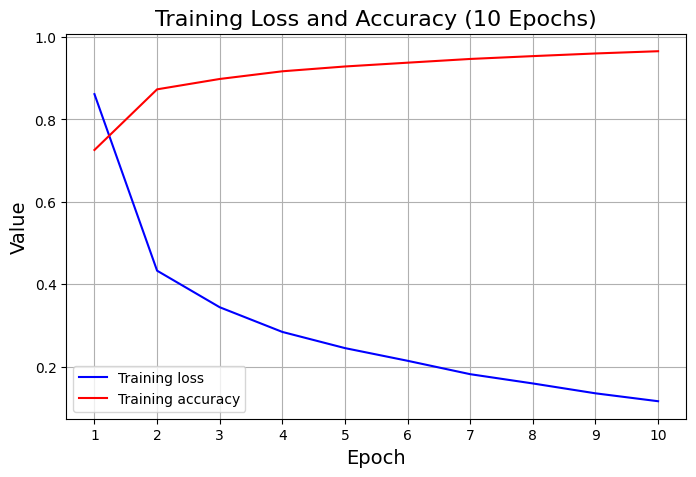

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))

    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')

    plt.grid(True)
    plt.title('Training Loss and Accuracy (10 Epochs)', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.xticks(range(1, len(train_losses) + 1))

    plt.show()

plot_metrics(train_losses_opt, train_accuracies_opt)

In [ ]:
model_optimizer.eval()


correct = 0
total = 0


with torch.no_grad():
    for data in testloader:

        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model_optimizer(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy of the model on the test images: {accuracy}%')


Accuracy of the model on the test images: 92.44775660725261%


In [ ]:

model_optimizer.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in mnist_testloader:

        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model_optimizer(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy of the model on the MNIST test images: {accuracy}%')


Accuracy of the model on the MNIST test images: 67.05%


### unsupervised

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


best_model = models.resnet18(pretrained=True)


num_classes = 10
best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)


In [ ]:
def grayscale_to_rgb(image):
    """Converts a grayscale image to a 3-channel RGB image by replication."""
    return image.repeat(3, 1, 1)

transform_train = transforms.Compose([

    transforms.Resize((32, 32)),

    transforms.ToTensor(),
    transforms.Lambda(grayscale_to_rgb),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(grayscale_to_rgb),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)


num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)



def train_model(model, criterion, optimizer, num_epochs, train_loader):
    train_losses = []
    train_accuracies = []
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        loss_epoch = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            loss_epoch.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(sum(loss_epoch)/len(loss_epoch))
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {sum(loss_epoch)/len(loss_epoch):.4f}, Train Accuracy: {train_accuracy:.4f}')

    return train_losses, train_accuracies

train_losses_uns, train_accuracies_uns = train_model(best_model, criterion, optimizer, num_epochs, trainloader)


Epoch 1/10 - Train Loss: 0.2047, Train Accuracy: 0.9474
Epoch 2/10 - Train Loss: 0.0903, Train Accuracy: 0.9783
Epoch 3/10 - Train Loss: 0.0672, Train Accuracy: 0.9838
Epoch 4/10 - Train Loss: 0.0438, Train Accuracy: 0.9884
Epoch 5/10 - Train Loss: 0.0410, Train Accuracy: 0.9896
Epoch 6/10 - Train Loss: 0.0338, Train Accuracy: 0.9913
Epoch 7/10 - Train Loss: 0.0290, Train Accuracy: 0.9923
Epoch 8/10 - Train Loss: 0.0261, Train Accuracy: 0.9937
Epoch 9/10 - Train Loss: 0.0196, Train Accuracy: 0.9945
Epoch 10/10 - Train Loss: 0.0202, Train Accuracy: 0.9944


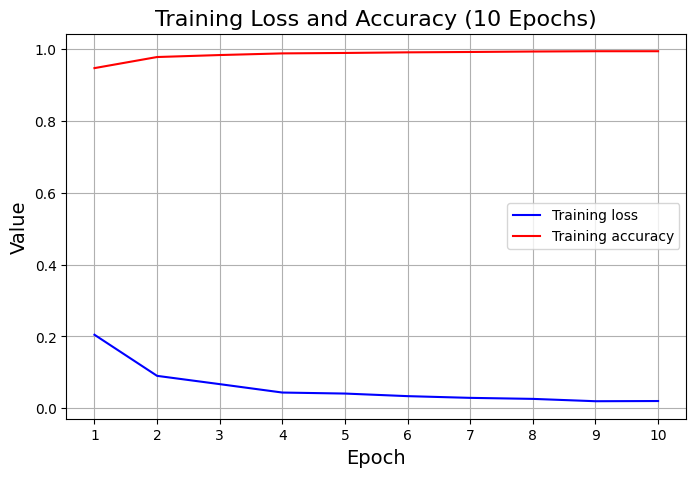

In [ ]:
plot_metrics(train_losses_uns, train_accuracies_uns)

In [ ]:
 best_model.eval()

 correct = 0
total = 0

 with torch.no_grad():
    for data in testloader:
         inputs, labels = data

         if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = best_model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = 100 * correct / total

print(f'Accuracy of the model on the MNIST test images: {accuracy}%')


Accuracy of the model on the MNIST test images: 99.29%


In [7]:
import torch
from torchvision import datasets, transforms

svhn_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4376, 0.4438, 0.4723), (0.2070, 0.2070, 0.2070))])

svhn_testset = datasets.SVHN(root='./data', split='test', download=True, transform=svhn_transform)
svhn_testloader = torch.utils.data.DataLoader(svhn_testset, batch_size=16, shuffle=False)


Using downloaded and verified file: ./data/test_32x32.mat


In [ ]:
best_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in svhn_testloader:
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = best_model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy of the model on the svhn test images: {accuracy}%')


Accuracy of the model on the svhn test images: 27.562231100184388%


### supervised

In [8]:
svhn_subset_size = 1000

svhn_full_testset = datasets.SVHN(root='./data', split='test', download=True, transform=svhn_transform)

svhn_subset_indices = torch.randperm(len(svhn_full_testset))[:svhn_subset_size]
svhn_subset = torch.utils.data.Subset(svhn_full_testset, svhn_subset_indices)


Using downloaded and verified file: ./data/test_32x32.mat


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp

best_model_sup = models.resnet18(pretrained=True)


num_classes = 10
best_model_sup.fc = nn.Linear(best_model_sup.fc.in_features, num_classes)


criterion = nn.CrossEntropyLoss(label_smoothing=0.25)
optimizer = optim.Adam(best_model_sup.parameters(), lr=0.001)

num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_sup.to(device)

train_losses_sup, train_accuracies_sup = train_model(best_model_sup, criterion, optimizer, num_epochs, trainloader)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Train Loss: 1.1437, Train Accuracy: 0.9538
Epoch 2/10 - Train Loss: 1.0772, Train Accuracy: 0.9819
Epoch 3/10 - Train Loss: 1.0597, Train Accuracy: 0.9871
Epoch 4/10 - Train Loss: 1.0525, Train Accuracy: 0.9894
Epoch 5/10 - Train Loss: 1.0469, Train Accuracy: 0.9917
Epoch 6/10 - Train Loss: 1.0433, Train Accuracy: 0.9931
Epoch 7/10 - Train Loss: 1.0414, Train Accuracy: 0.9937
Epoch 8/10 - Train Loss: 1.0388, Train Accuracy: 0.9950
Epoch 9/10 - Train Loss: 1.0377, Train Accuracy: 0.9957
Epoch 10/10 - Train Loss: 1.0364, Train Accuracy: 0.9964


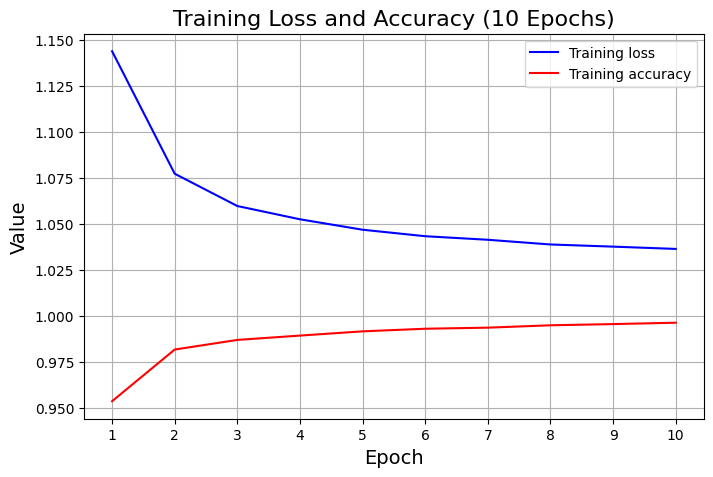

In [51]:
plot_metrics(train_losses_sup, train_accuracies_sup)

In [47]:
svhn_subset_size = 1000

svhn_full_testset = datasets.SVHN(root='./data', split='test', download=True, transform=svhn_transform)

svhn_subset_indices = torch.randperm(len(svhn_full_testset))[:svhn_subset_size]
svhn_subset = torch.utils.data.Subset(svhn_full_testset, svhn_subset_indices)

svhn_subset_loader = torch.utils.data.DataLoader(svhn_subset, batch_size=16, shuffle=False)

Using downloaded and verified file: ./data/test_32x32.mat


In [48]:
for param in best_model_sup.parameters():
    param.requires_grad = False  #

# Unfreeze parameters only for the last layer
for param in best_model_sup.fc.parameters():
    param.requires_grad = True

train_losses = []
train_accuracies = []
scaler = amp.GradScaler()

for epoch in range(num_epochs):
    best_model_sup.train()
    correct = 0
    total = 0
    loss_epoch = []

    for inputs, labels in svhn_subset_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with amp.autocast():
            outputs = best_model_sup(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_epoch.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(sum(loss_epoch)/len(loss_epoch))
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {sum(loss_epoch)/len(loss_epoch):.4f}, Train Accuracy: {train_accuracy:.4f}')


Epoch 1/10 - Train Loss: 2.1780, Train Accuracy: 0.3570
Epoch 2/10 - Train Loss: 2.0474, Train Accuracy: 0.3760
Epoch 3/10 - Train Loss: 2.0114, Train Accuracy: 0.3890
Epoch 4/10 - Train Loss: 1.9914, Train Accuracy: 0.4000
Epoch 5/10 - Train Loss: 1.9767, Train Accuracy: 0.4050
Epoch 6/10 - Train Loss: 1.9649, Train Accuracy: 0.4130
Epoch 7/10 - Train Loss: 1.9549, Train Accuracy: 0.4260
Epoch 8/10 - Train Loss: 1.9462, Train Accuracy: 0.4300
Epoch 9/10 - Train Loss: 1.9384, Train Accuracy: 0.4330
Epoch 10/10 - Train Loss: 1.9314, Train Accuracy: 0.4390


In [49]:
best_model_sup.eval()


correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = best_model_sup(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy of the model on the MNIST test images: {accuracy}%')


Accuracy of the model on the MNIST test images: 76.89%


In [50]:
best_model_sup.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in svhn_testloader:
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = best_model_sup(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy of the model on the svhn test images: {accuracy}%')

Accuracy of the model on the svhn test images: 39.94698832206515%
